# Cubic Spline Interpolation

In [1]:
from sympy import *
import numpy as np
import math

## Cubic Spline Functions

In [214]:
def natural_cubic_spline(N, data_points):
    ''' natural cubic spline coefficients solver
    '''
    # a,b,c,d initialization
    a = np.array([data_points[i][1] for i in range(len(data_points))])
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    
    # step 1
    h=np.array([data_points[i+1][0]-data_points[i][0] for i in range(N-1)])
    
    # step 2
    alpha = np.zeros(N-1)
    for i in range(N-1):
        alpha[i] = 3*(a[i+1]-a[i])/h[i] - 3*(a[i]-a[i-1])/h[i-1]
        
    # step 3
    l = np.zeros(N)
    miu = np.zeros(N)
    z = np.zeros(N)
    l[0] = 1
    
    # step 4
    for i in range(1, N-1):
        l[i] = 2*(data_points[i+1][0] - data_points[i-1][0]) - (h[i-1]*miu[i-1])
        miu[i] = h[i]/l[i]
        z[i] = (alpha[i]-(h[i-1]*z[i-1]))/l[i]
        
    # step 5
    l[N-1] = 1
    z[N-1] = 0
    c[N-1] = 0
    
    # step 6
    for j in range(N-2, -1, -1):
        c[j] = z[j] - miu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - (h[j]*(c[j+1]+2*c[j])/3)
        d[j] = (c[j+1]-c[j])/(3*h[j])
        
    return a,b,c,d

def clamped_cubic_spline(N, data_points, FPO, FPN):
    ''' clamped cubic spline coefficients solver
    '''
    
    # a,b,c,d initialization
    a = np.array([data_points[i][1] for i in range(len(data_points))])
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    
    # step 1
    h=np.array([data_points[i+1][0]-data_points[i][0] for i in range(N-1)])
    
    # step 2
    alpha = np.zeros(N)
    alpha[0]=(3*(a[1]-a[0])/h[0]) - 3*FPO
    alpha[N-1] = (3*FPN) - (3*(a[N-1]-a[N-2])/h[N-2])
    
    #step 3
    for i in range(1, N-1):
        alpha[i] = 3*(a[i+1]-a[i])/h[i] - 3*(a[i]-a[i-1])/h[i-1]
        
    # step 4
    l = np.zeros(N)
    miu = np.zeros(N)
    z = np.zeros(N)
    l[0] = 2*h[0]
    miu[0] = 0.5
    z[0] = alpha[0]/l[0]
    
    # step 5
    for i in range(1, N-1):
        l[i] = 2*(data_points[i+1][0] - data_points[i-1][0]) - (h[i-1]*miu[i-1])
        miu[i] = h[i]/l[i]
        z[i] = (alpha[i]-(h[i-1]*z[i-1]))/l[i]
        
    # step 6
    l[N-1] = h[N-2]*(2-miu[N-2])
    z[N-1] = (alpha[N-1] - (h[N-2]*z[N-2]))/l[N-1]
    c[N-1] = z[N-1]
    
    # step 7
    for j in range(N-2, -1, -1):
        c[j] = z[j] - miu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - (h[j]*(c[j+1]+2*c[j])/3)
        d[j] = (c[j+1]-c[j])/(3*h[j])
        
    return a,b,c,d

def spline_functions_generator(data_points, a, b, c, d):
    '''generate Si(x) functions'''
    x = Symbol('x')
    # S(x) definition
    Sx = lambda x, xj, a, b, c, d : a + (b*(x-xj)) + (c*(x-xj)**2) + ((d*(x-xj)**3))
    S = [Sx(x, data_points[i][0], a[i], b[i], c[i],d[i]) for i in range(N-1)]
    return S


def interpolate_single_point(data_points, x_val, S):
    y = S[len(data_points)-2].evalf(subs={x:x_val})
    for i in range(len(data_points)-1):
        if x_val<=data_points[i+1][0]:
            y = S[i].evalf(subs={x:x_val})
            break
    return y

def interpolated_data_generator(data_points, step, S):
    '''generate interpolation of (x,f(x))
    '''
    y_points = np.array([np.zeros(int((data_points[i+1][0]-data_points[i][0])/step)) for i in range(N-1)])
    x_points = np.array([np.linspace(data_points[i][0], data_points[i+1][0], int((data_points[i+1][0]-data_points[i][0])/step)) for i in range(N-1)])
    for i in range(N-1):
        for j in range(len(y_points[i])):
            y_points[i][j] = S[i].evalf(subs={x:x_points[i][j]})
    x_points=x_points.flatten()
    y_points=y_points.flatten()
    return x_points, y_points



### Example 2 page 150

$$f(x) = e^x$$

In [215]:
#example 2 pg 150
precision = 5
f = lambda c, precision : exp(c).evalf(precision)
data_points=np.array([[0,1],
                      [1, f(1,precision)],
                      [2, f(2,precision)],
                      [3, f(3,precision)]]
                    )
N = len(data_points)
a,b,c,d = natural_cubic_spline(N, data_points)
# create the S(x) functions
S = spline_functions_generator(data_points, a, b, c, d)
print("a = ",a)
print("b = ",b)
print("c = ",c)
print("d = ",d)
print("S(x) : ")
for i in range(len(S)):
    print(S[i])
print()
x_val = 0.5
print("Single point interpolation of x=",x_val," :")
print("interpolation = ",interpolate_single_point(data_points, x_val, S),
      "\nreal value from function = ",f(x_val,precision))
# for plotting purpose
step = 0.01
#generate interpolated data points
x_int, y_int = interpolated_data_generator(data_points, step, S)
y_func = np.array([f(x_int[i], precision) for i in range(len(x_int))])

a =  [1 2.7183 7.3891 20.086]
b =  [1.46599672 2.22285021 8.80977139 0.        ]
c =  [0.         0.75685221 5.83007406 0.        ]
d =  [ 0.25228407  1.69107395 -1.94335802  0.        ]
S(x) : 
0.252284071180556*x**3 + 1.46599672105577*x + 1
2.22285020616319*x + 1.69107394748264*(x - 1)**3 + 0.756852213541667*(x - 1)**2 + 0.495430586073134
8.80977138943142*x - 1.94335801866319*(x - 2)**3 + 5.83007405598958*(x - 2)**2 - 10.2304894341363

Single point interpolation of x= 0.5  :
interpolation =  1.76453386942546 
real value from function =  1.6487


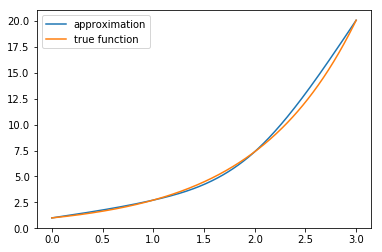

In [216]:
import matplotlib.pyplot as plt
plt.plot(x_points, y_points, label="approximation")
plt.plot(x_points, y_func, label="true function")
plt.legend(loc="upper left")
plt.show()

### Exercise 5d Page 161

$$f(x) = x \cos(x)-2x^2+3x-1
$$

In [217]:
# exercise 5d
x = Symbol('x')
f = lambda x: x*cos(x)-(2*x**2)+(3*x)-1
f_dx = diff(f(x), x)

# interpolation of f(x)
data_points = np.array([[0.1, f(0.1)],
                        [0.2, f(0.2)],
                        [0.3, f(0.3)],
                        [0.4, f(0.4)]]
                      )
N = len(data_points)
a,b,c,d = natural_cubic_spline(N, data_points)
S = spline_functions_generator(data_points, a, b, c, d)
x_val = 0.25
y = interpolate_single_point(data_points, x_val, S)
err = abs(y-f(x_val))

print("x = ",x_val)
print("interpolated f(x) = ",y)
print("true f(x) = ",f(x_val))
print("error = ",err)
print()


# interpolation of f'(x)
data_points = np.array([[0.1, f_dx.evalf(subs={x:0.1})],
                        [0.2, f_dx.evalf(subs={x:0.2})],
                        [0.3, f_dx.evalf(subs={x:0.3})],
                        [0.4, f_dx.evalf(subs={x:0.4})]]
                      )
N = len(data_points)
a,b,c,d = natural_cubic_spline(N, data_points)
S = spline_functions_generator(data_points, a, b, c, d)
x_val = 0.25
y = interpolate_single_point(data_points, x_val, S)
err = abs(y-f_dx.evalf(subs={x:x_val}))

print("x = ",x_val)
print("interpolated f'(x) = ",y)
print("true f'(x) = ",f_dx.evalf(subs={x:x_val}))
print("error = ",err)
print()


x =  0.25
interpolated f(x) =  -0.131591160233762
true f(x) =  -0.132771894572339
error =  0.00118073433857688

x =  0.25
interpolated f'(x) =  2.90775896876347
true f'(x) =  2.90706143189701
error =  0.000697536866452797



### Exercise 7d Page 161

In [218]:
# exercise 7d
x = Symbol('x')
f = lambda x: x*cos(x)-(2*x**2)+(3*x)-1
f_dx = diff(f(x), x)

data_points = np.array([[0.1, f(0.1)],
                        [0.2, f(0.2)],
                        [0.3, f(0.3)],
                        [0.4, f(0.4)]]
                      )
N = len(data_points)
FPO = f_dx.evalf(subs={x:0.1})
FPN = f_dx.evalf(subs={x:0.4})
a,b,c,d = clamped_cubic_spline(N, data_points, FPO, FPN)
S = spline_functions_generator(data_points, a, b, c, d)
x_val = 0.25
y = interpolate_single_point(data_points, x_val, S)
err = abs(y-f(x_val))
print("x = ",x_val)
print("interpolated f(x) = ",y)
print("true f(x) = ",f(x_val))
print("error = ",err)
print()
print("a = ",a)
print("b = ",b)
print("c = ",c)
print("d = ",d)
print("S(x) : ")
for i in range(len(S)):
    print(S[i])

x =  0.25
interpolated f(x) =  -0.132772217685471
true f(x) =  -0.132771894572339
error =  3.23113132361108e-7

a =  [-0.620499583472197 -0.283986684431752 0.00660094673768175
 0.248424397601154]
b =  [3.58502082 3.14032944 2.66667734 0.        ]
c =  [-2.14984111 -2.29707277 -2.43944816 -2.5743887 ]
d =  [-0.49077221 -0.47458461 -0.4498018   0.        ]
S(x) : 
3.58502082361334*x - 0.490772207394706*(x - 0.1)**3 - 2.14984111134938*(x - 0.1)**2 - 0.979001665833532
3.14032943512162*x - 0.474584607051173*(x - 0.2)**3 - 2.2970727735678*(x - 0.2)**2 - 0.912052571456077
2.66667734219653*x - 0.449801799349201*(x - 0.3)**3 - 2.43944815568315*(x - 0.3)**2 - 0.793402255921277


### Exercise 28 Page 163

In [222]:
# exercise 28 pg 163
x = Symbol('x')
data_points = np.array([[1950, 151326],
                        [1960, 179323],
                        [1970, 203302],
                        [1980, 226542],
                        [1990, 249633],
                        [2000, 281422]
                       ]
                      )
N = len(data_points)
a,b,c,d = natural_cubic_spline(N, data_points)
S = spline_functions_generator(data_points, a, b, c, d)


print("a = ",a)
print("b = ",b)
print("c = ",c)
print("d = ",d)
print("S(x) : ")
for i in range(len(S)):
    print(S[i])
print()
x_vals = [1940, 1975, 2020]
ys = [interpolate_single_point(data_points, x_vals[i], S) for i in range(len(x_vals))]
print("x\tinterpolated_f(x)")
for i in range(len(x_vals)):
    print(str(x_vals[i])+"\t"+str(ys[i]))

a =  [151326 179323 203302 226542 249633 281422]
b =  [2906.50239234 2586.09521531 2341.91674641 2211.93779904 2709.63205742
    0.        ]
c =  [  0.         -32.0407177    7.62287081 -20.62076555  70.39019139
   0.        ]
d =  [-1.06802392  1.32211962 -0.94145455  3.03369856 -2.34633971  0.        ]
S(x) : 
2906.5023923445*x - 1.06802392344498*(x - 1950)**3 - 5516353.66507177
2586.095215311*x + 1.32211961722488*(x - 1960)**3 - 32.0407177033493*(x - 1960)**2 - 4889423.62200957
2341.91674641148*x - 0.941454545454546*(x - 1970)**3 + 7.62287081339714*(x - 1970)**2 - 4410273.99043062
2211.93779904306*x + 3.0336985645933*(x - 1980)**3 - 20.6207655502392*(x - 1980)**2 - 4153094.84210526
2709.63205741627*x - 2.34633971291866*(x - 1990)**3 + 70.3901913875598*(x - 1990)**2 - 5142534.79425837

x	interpolated_f(x)
1940	123329.000000000
1975	215084.473684211
2020	330921.961722488
